In [193]:
from collections import Counter
import datetime
from functools import reduce
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize.casual import TweetTokenizer
#from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import spacy
from spacy.lang.en import English
from spacy import displacy
#!python -m spacy download en_core_web_md #you will need to install this on first load

#nlp = spacy.load('en_core_web_md')

import tensorflow as tf
import tensorflow_hub as hub


nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')


[nltk_data] Downloading package wordnet to /home/priyav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/priyav/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/priyav/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

Use only the words in Google's word2vec so that comparsions can be made with embeddings only performance

In [210]:
with open('data/tweet_doc_word2vec_datasets.pkl', 'rb') as f:
    word_freqs = pickle.load(f)
    
token_arr = word_freqs['train']['tokens']
vocab = word_freqs['vocab']

idx_to_vocab = dict(zip(range(len(vocab)), vocab))

# replace numbers in token array with words
word_arr = [[idx_to_vocab.get(t) for t in tokens] for tokens in token_arr]


In [211]:
# create a dictionary of the words in tweets
dictionary = corpora.Dictionary(word_arr)

# filter out words that appear too often or not often enough
dictionary.filter_extremes(no_below=15, no_above=0.4, keep_n=100000)

# create a bag of words corpus
bow_corpus = [dictionary.doc2bow(text) for text in word_arr]



Text(0.5, 0, 'Number of occurences of word in tweets')

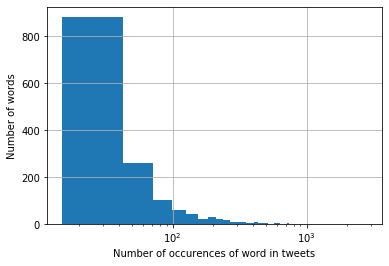

In [212]:
fig, ax = plt.subplots()
pd.Series(list(dictionary.dfs.values())).hist(bins=100, ax=ax)
ax.set_xscale('log')
ax.set_ylabel('Number of words')
ax.set_xlabel('Number of occurences of word in tweets')


Get the parts of speech that are most often used, as well as frequency within these POS.
https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b

['ADJ' 'VERB' 'NOUN' 'ADV' 'PRON' 'CONJ' 'ADP' 'DET' 'NUM' '.']


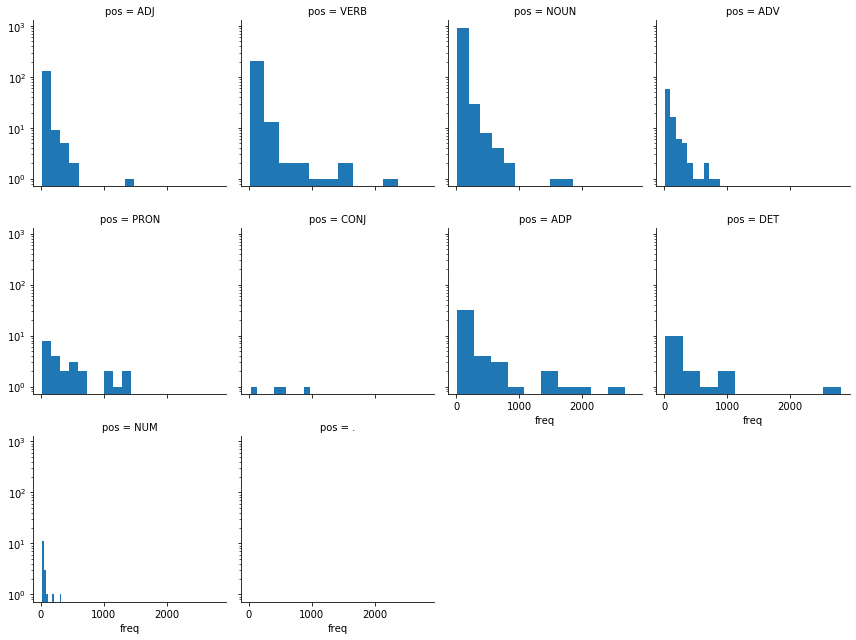

In [213]:
pos_df = pd.DataFrame([[v, k, nltk.pos_tag([k], tagset='universal')[0][1]] for k, v in dictionary.token2id.items()],
                        columns=['id', 'token', 'pos'])

token_freq = pd.DataFrame([[k,v] for k, v in dictionary.dfs.items()],
                          columns=['id', 'freq'])
pos_freq_df = pd.merge(pos_df, token_freq, on='id')

print(pos_freq_df['pos'].unique())

# plot, subset by part of speech, frequency of words
g = sns.FacetGrid(pos_freq_df, col='pos', col_wrap=4)
g.map(plt.hist, "freq", log=True)                  

In [216]:
# look at the adverbs most frequently seen
print(pos_freq_df[pos_freq_df.pos == "ADV"].sort_values("freq", ascending=False))

# look at the adjectives most frequently seen
print(pos_freq_df[pos_freq_df.pos == "ADJ"].sort_values("freq", ascending=False))

# look at the nouns most frequently seen
print(pos_freq_df[pos_freq_df.pos=="NOUN"].sort_values("freq", ascending=False))


# look at the verbs most frequently seen
print(pos_freq_df[pos_freq_df.pos=="VERB"].sort_values("freq", ascending=False))


        id          token  pos  freq
145    145            not  ADV   890
105    105           very  ADV   737
182    182             so  ADV   666
198    198            now  ADV   632
304    304           just  ADV   606
144    144           more  ADV   502
3        3             up  ADV   427
36      36          there  ADV   417
190    190          never  ADV   357
183    183           when  ADV   344
226    226           even  ADV   320
111    111           back  ADV   288
135    135           only  ADV   279
269    269          again  ADV   257
327    327          first  ADV   242
164    164           ever  ADV   241
825    825            why  ADV   215
740    740           also  ADV   203
393    393            how  ADV   201
148    148         really  ADV   188
599    599           down  ADV   184
657    657           long  ADV   172
517    517         better  ADV   169
350    350           well  ADV   169
977    977            far  ADV   165
340    340        forward  ADV   155
7

Now create a topic model

In [217]:
# create an lda model 
num_topics = 20
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=50, workers=2)

In [218]:
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.207*"retweet" + 0.033*"A" + 0.030*"is" + 0.029*"president" + 0.027*"in"')
(1, '0.027*"retweet" + 0.023*"in" + 0.023*"i" + 0.021*"for" + 0.020*"love"')
(2, '0.034*"is" + 0.023*"for" + 0.022*"have" + 0.021*"better" + 0.019*"than"')
(3, '0.041*"on" + 0.039*"will" + 0.035*"be" + 0.029*"A" + 0.028*"at"')
(4, '0.155*"you" + 0.108*"thank" + 0.042*"for" + 0.042*"great" + 0.033*"your"')
(5, '0.042*"more" + 0.033*"than" + 0.021*"trump" + 0.021*"two" + 0.020*"in"')
(6, '0.034*"great" + 0.034*"A" + 0.029*"he" + 0.029*"is" + 0.029*"for"')
(7, '0.020*"have" + 0.019*"is" + 0.017*"they" + 0.016*"has" + 0.016*"that"')
(8, '0.030*"that" + 0.021*"with" + 0.021*"in" + 0.017*"trump" + 0.017*"was"')
(9, '0.023*"is" + 0.022*"on" + 0.021*"A" + 0.016*"was" + 0.015*"that"')
(10, '0.041*"in" + 0.030*"country" + 0.030*"our" + 0.023*"history" + 0.023*"is"')
(11, '0.027*"news" + 0.026*"fake" + 0.024*"i" + 0.023*"is" + 0.020*"A"')
(12, '0.026*"A" + 0.025*"witch" + 0.025*"hunt" + 0.024*"no" + 0.018*"is"')
(13,

This suggests that some preopositions, the word retweet, the pronouns, being verbs should be removed

In [223]:
# filter word_array for Part of speech
def filter_word(w):
    # needed to omit some verbs that are also nouns: may, might
    being_verbs = ['A', 'to', 'be', 'am', 'is', 'are', 'was', 'were', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'can', 'could', 'shall', 'should', 'will', 'must']
    valid_pos = ['ADJ', 'NOUN', 'ADV', 'VERB', 'NUM']
    other_disallowed = ['retweet', '....', '.....', 'how', 'who', 'what', 'when', 'where', 'why', "n'\t", "n\'t'", "i", 'so']
    
    if w not in being_verbs:
        if w not in other_disallowed:
            if nltk.pos_tag([w], tagset='universal')[0][1] in valid_pos:
    
                return(True)
    return(False)

filt_pos_arr = [list(filter(filter_word, words)) for words in word_arr]


In [224]:
# create a dictionary of the words in tweets
dictionary_filt = corpora.Dictionary(filt_pos_arr)

# filter out words that appear too often or not often enough
dictionary_filt.filter_extremes(no_below=15, no_above=0.4, keep_n=100000)

# create a bag of words corpus
bow_corpus_filt = [dictionary_filt.doc2bow(text) for text in filt_pos_arr]

# create an lda model 
num_topics = 20
lda_model_filt = gensim.models.LdaMulticore(bow_corpus_filt, num_topics=num_topics, id2word=dictionary_filt, passes=50, workers=2)


In [225]:
topics_filt = lda_model_filt.print_topics(num_words=5)
print("Top 5 words for each topic")
for topic in topics_filt:
    print("Topic {}: {}".format(topic[0], topic[1]))
    
# would be dope to use word cloud
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

Top 5 words for each topic
Topic 0: 0.073*"great" + 0.060*"america" + 0.039*"again" + 0.035*"make" + 0.029*"strong"
Topic 1: 0.037*"nothing" + 0.026*"president" + 0.023*"said" + 0.022*"just" + 0.019*"not"
Topic 2: 0.020*"great" + 0.019*"presidential" + 0.018*"american" + 0.017*"down" + 0.016*"terrible"
Topic 3: 0.092*"united" + 0.080*"states" + 0.024*"president" + 0.023*"ca" + 0.021*"general"
Topic 4: 0.031*"just" + 0.026*"good" + 0.017*"really" + 0.017*"highly" + 0.017*"world"
Topic 5: 0.034*"great" + 0.033*"day" + 0.022*"north" + 0.021*"FLOTUS" + 0.021*"tonight"
Topic 6: 0.038*"most" + 0.036*"ever" + 0.032*"history" + 0.027*"one" + 0.024*"congress"
Topic 7: 0.022*"very" + 0.021*"china" + 0.020*"president" + 0.019*"great" + 0.018*"meeting"
Topic 8: 0.139*"thank" + 0.029*"great" + 0.021*"years" + 0.019*"done" + 0.017*"maga"
Topic 9: 0.042*"trump" + 0.031*"president" + 0.025*"american" + 0.023*"not" + 0.023*"biden"
Topic 10: 0.031*"U.S." + 0.022*"jobs" + 0.020*"very" + 0.019*"more" + 0.

   dominant_topic_num  num_words dominant_topic
0                   0          5        topic 0
1                  12          5       topic 12
2                  15         21       topic 15
3                  17         18       topic 17
4                   0          6        topic 0


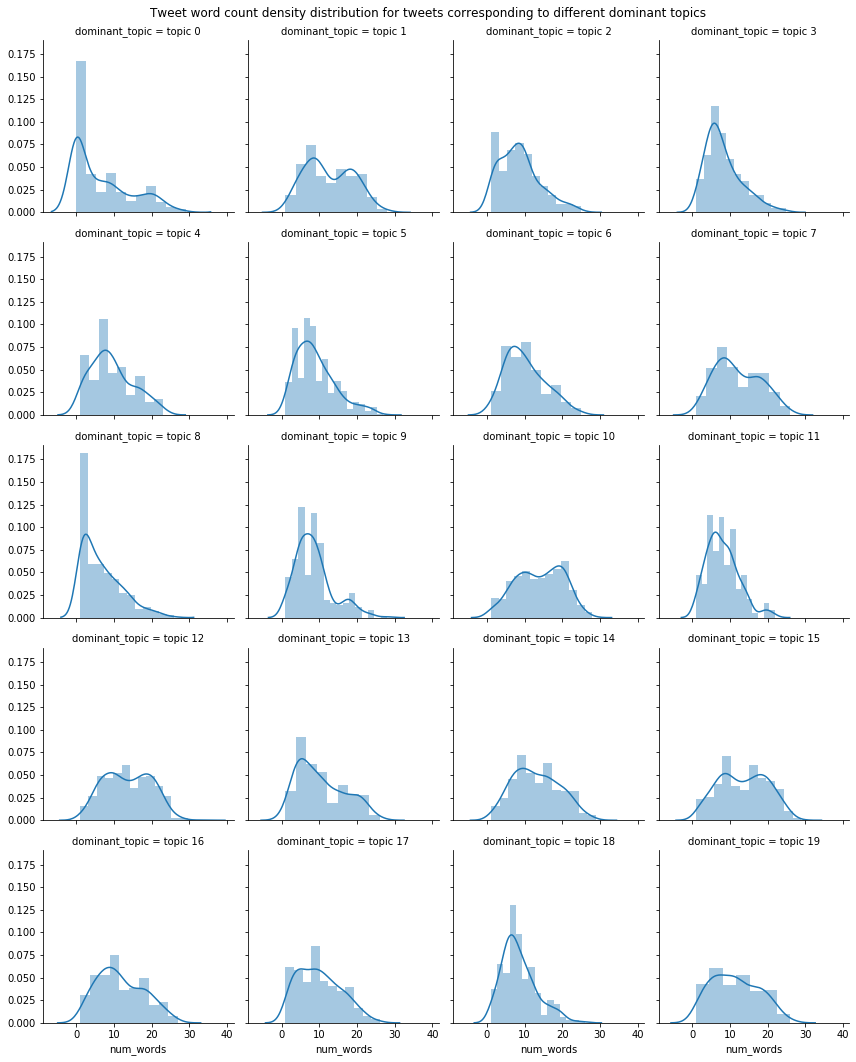

In [226]:
# look at number of words in dominant topic for each document
def get_dominant_topic(lda_model, corpus):
    scores = lda_model[corpus]
    dominant_topics = [[x[0] for x in doc_score][np.argmax([x[1] for x in doc_score])] for doc_score in scores]
    return(dominant_topics)

def get_num_words(corpus):
    return([len(c) for c in corpus])



#for i, ax in enumerate(axes.flatten()):    
df_dominant_topic_wc = pd.DataFrame({'dominant_topic_num' :  get_dominant_topic(lda_model_filt,
                                                                               bow_corpus_filt),
                                         'num_words' : get_num_words(bow_corpus_filt)})
df_dominant_topic_wc['dominant_topic'] = ["topic {}".format(x) for x in df_dominant_topic_wc.dominant_topic_num]
print(df_dominant_topic_wc.head())
g = sns.FacetGrid(df_dominant_topic_wc.sort_values('dominant_topic_num'), col='dominant_topic', col_wrap=4)


g.map(sns.distplot, "num_words")
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Tweet word count density distribution for tweets corresponding to different dominant topics') # can also get the figure from plt.gcf()
plt.savefig('plots/topic_model_simple_word_count_distplot.png')   

In [227]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_filt, bow_corpus_filt, dictionary=lda_model_filt.id2word)
vis

/home/priyav/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10     0.123010  0.038327       1        1  8.764033
15     0.183200  0.052407       2        1  8.188736
12     0.142879  0.111714       3        1  7.352414
14     0.187091 -0.193357       4        1  6.962838
1      0.044149  0.081116       5        1  5.541366
0     -0.093594 -0.254047       6        1  5.306055
17    -0.111673 -0.045176       7        1  5.242990
5     -0.175526  0.007422       8        1  5.015629
16     0.106277 -0.261061       9        1  4.726113
7      0.035029  0.083384      10        1  4.689801
13    -0.008895 -0.052124      11        1  4.450325
18    -0.110513  0.009516      12        1  4.258870
19     0.135643  0.064205      13        1  4.238377
4     -0.100862  0.059511      14        1  4.102997
8     -0.139998 -0.043373      15        1  3.850039
9     -0.025887  0.095947      16        1  3.827576
6     -0.055129  0.038006      17        1  3.611667
3     -0.037418  0.043769      18        1  3.321743
2      0.073345  0.105046      19        1  3.282593
11    -0.171127  0.058768      20        1  3.265840, topic_info=     Category         Freq             Term        Total  loglift  logprob
2     Default   479.000000            thank   479.000000  30.0000  30.0000
7     Default   528.000000             news   528.000000  29.0000  29.0000
6     Default   462.000000             fake   462.000000  28.0000  28.0000
0     Default  1456.000000            great  1456.000000  27.0000  27.0000
669   Default   326.000000           united   326.000000  26.0000  26.0000
436   Default   369.000000            today   369.000000  25.0000  25.0000
667   Default   298.000000           states   298.000000  24.0000  24.0000
204   Default   363.000000          america   363.000000  23.0000  23.0000
75    Default   440.000000           border   440.000000  22.0000  22.0000
318   Default   359.000000            media   359.000000  21.0000  21.0000
79    Default   608.000000        democrats   608.000000  20.0000  20.0000
27    Default   253.000000            witch   253.000000  19.0000  19.0000
19    Default   252.000000             hunt   252.000000  18.0000  18.0000
93    Default   756.000000        president   756.000000  17.0000  17.0000
38    Default   384.000000              new   384.000000  16.0000  16.0000
69    Default   667.000000            trump   667.000000  15.0000  15.0000
198   Default   279.000000            again   279.000000  14.0000  14.0000
151   Default   207.000000          nothing   207.000000  13.0000  13.0000
301   Default   366.000000             U.S.   366.000000  12.0000  12.0000
167   Default   291.000000             make   291.000000  11.0000  11.0000
10    Default   216.000000        collusion   216.000000  10.0000  10.0000
117   Default   259.000000             ever   259.000000   9.0000   9.0000
9     Default   332.000000         american   332.000000   8.0000   8.0000
230   Default   630.000000             just   630.000000   7.0000   7.0000
249   Default   173.000000  congratulations   173.000000   6.0000   6.0000
227   Default   236.000000              day   236.000000   5.0000   5.0000
72    Default   254.000000                %   254.000000   4.0000   4.0000
142   Default   635.000000              now   635.000000   3.0000   3.0000
135   Default   344.000000            never   344.000000   2.0000   2.0000
362   Default   188.000000             most   188.000000   1.0000   1.0000
...       ...          ...              ...          ...      ...      ...
833   Topic20    26.783066          elected    35.947742   3.1274  -4.6899
311   Topic20     8.277275           career    11.249310   3.1149  -5.8642
1258  Topic20    30.149754          alabama    41.094608   3.1120  -4.5715
490   Topic20    16.458611           friday    22.849531   3.0936  -5.1769
1006  Topic20    42.613235           action    59.489880   3.0880  -4.2255
1043  Topic20   

In [228]:
# get topic probability as a vector for each of the training, test, validation corpus
# Set 0 probability if topic does not appear
#valid_token_arr = [[idx_to_vocab.get(t) for t in tokens] for tokens in word_freqs['validation']['tokens']]
#valid_corpus = [dictionary_filt.doc2bow(text) for text in [list(filter(filter_word, words)) for words in valid_token_arr]]
#valid_corpus_idx = list(zip(word_freqs['valid_idx'].tolist(), valid_corpus))

#test_token_arr = [[idx_to_vocab.get(t) for t in tokens] for tokens in word_freqs['test']['tokens']]
#test_corpus = [dictionary_filt.doc2bow(text) for text in [list(filter(filter_word, words)) for words in test_token_arr]]
#test_corpus_idx = list(zip(word_freqs['test_idx'], test_corpus))

#train_corpus_idx = list(zip(word_freqs['train_idx'].tolist(), bow_corpus_filt))

#all_corpus_idx = train_corpus_idx + valid_corpus_idx + test_corpus_idx
#all_corpus_idx.sort(key=lambda x: x[0])

#all_corpus = [x[1] for x in all_corpus_idx]
tweet_corpus = [dictionary_filt.doc2bow(text) for text in [list(filter(filter_word, words)) for words in word_freqs['tweet_tokens']]]

topic_weights = []
n_topics = 20
for i, row_list in enumerate(lda_model_filt[tweet_corpus]):
    w = np.zeros(20)
    [np.put(w, x[0], x[1]) for x in row_list]
    topic_weights.append(w.tolist())

# Array of topic weights    
topic_weights_df = pd.DataFrame(topic_weights)
arr = topic_weights_df.values
# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]


In [229]:
# save topic weights
# first add date information (these tokens originally came from cleaned_tweets)
clean_tweets = pd.read_csv('cleaned_tweets')
clean_tweets.columns
topic_weights_df['Date'] = clean_tweets.apply(lambda x: datetime.date(int(x.year), int(x.month), int(x.day)), axis=1)

# now save to file
topic_weights_df.to_csv('data/topic_model_simple_weights.csv', index=False)


In [230]:
from sklearn.manifold import TSNE
# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8118 samples in 0.159s...
[t-SNE] Computed neighbors for 8118 samples in 4.912s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8118
[t-SNE] Computed conditional probabilities for sample 2000 / 8118
[t-SNE] Computed conditional probabilities for sample 3000 / 8118
[t-SNE] Computed conditional probabilities for sample 4000 / 8118
[t-SNE] Computed conditional probabilities for sample 5000 / 8118
[t-SNE] Computed conditional probabilities for sample 6000 / 8118
[t-SNE] Computed conditional probabilities for sample 7000 / 8118
[t-SNE] Computed conditional probabilities for sample 8000 / 8118
[t-SNE] Computed conditional probabilities for sample 8118 / 8118
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.928780
[t-SNE] KL divergence after 1000 iterations: 1.342914


      TSNE_1     TSNE_2 topic_num
0  13.790993  -8.986953   Topic 7
1  29.457109 -31.118561   Topic 9
2  13.120660   4.544684  Topic 19
3  19.032843   2.155450  Topic 19
4 -25.070538  24.352552  Topic 14


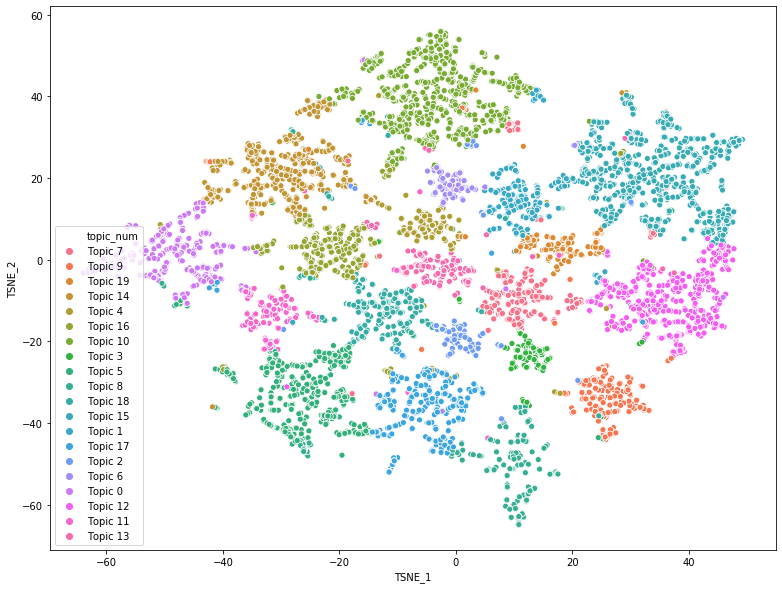

In [231]:
import matplotlib.colors as mcolors

plt.figure(figsize=(13, 10))
tsne_lda_df = pd.DataFrame(tsne_lda,
             columns=["TSNE_1", "TSNE_2"])
tsne_lda_df['topic_num'] = ["Topic {}".format(t) for t in np.argmax(arr, axis=1)]

print(tsne_lda_df.head())
sns.scatterplot(data=tsne_lda_df, x='TSNE_1', y='TSNE_2', hue='topic_num')


Compare existing keywords to topics

In [209]:
cleaned_tweets = pd.read_csv('cleaned_tweets')
keywords = [s.split("_")[1].lower() for s in filter(lambda x: "keyword" in x,  cleaned_tweets.columns)]
keywords

['china',
 'russia',
 'mexico',
 'canada',
 'korea',
 'clinton',
 'democrats',
 'republicans',
 'himself',
 'family',
 'government',
 'media',
 'states',
 'social',
 'obama',
 'fbi',
 'rivals',
 'middleeast',
 'ukraine',
 'economy',
 'disaster']